### Imports

In [ ]:
import sys
sys.dont_write_bytecode = True


import torch
import numpy as np
import random
import os

def set_seeds(seed_value=42):
    """Sets seeds for reproducibility."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)

set_seeds(42) 

import json
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import warnings
import logging
from datetime import datetime
warnings.filterwarnings('ignore')

from model import get_model
from config import CFG
from dataset import get_dataset_class
from resnet.plot import plot_domainwise_accuracy
from transform import get_transforms
from runner import run_baseline, run_lodo

torch.manual_seed(CFG["system"]["seed"])
np.random.seed(CFG["system"]["seed"])

device = CFG["system"]["device"]
print(f"Device: {device}")
print(f"PyTorch: {torch.__version__}")

DS = "PACS"
MODEL_NAME = "resnet18"

Device: cuda
PyTorch: 2.5.1+cu121


### DataLoading

In [ ]:
train_transform, test_transform = get_transforms(img_size=224, augment=False, use_imagenet_norm=False)

DatasetClass = get_dataset_class(DS)

ld = DatasetClass(
    data_root=CFG["datasets"][DS]["root"],
    transform=train_transform,
    batch_size=CFG["train"]["batch_size"]
)

print("\nData loaders ready!")


Data loaders ready!


### Logging

In [ ]:
dataset_name = DS
base_dir = os.path.join(os.getcwd(), dataset_name)
subdirs = ["logs", "checkpoints", "plots"]

for sub in subdirs:
    os.makedirs(os.path.join(base_dir, sub), exist_ok=True)

timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
log_file = os.path.join(base_dir, "logs", f"train_{timestamp}.log")

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s",
    handlers=[
        logging.FileHandler(log_file),
        logging.StreamHandler()
    ]
)

logger = logging.getLogger(f"{dataset_name}_logger")

logger.info(f"Initialized experiment directories for {dataset_name}")
logger.info(f"Logs: {os.path.join(base_dir, 'logs')}")
logger.info(f"Checkpoints: {os.path.join(base_dir, 'checkpoints')}")
logger.info(f"Plots: {os.path.join(base_dir, 'plots')}")

2025-10-11 07:27:37,057 | INFO | Initialized experiment directories for PACS
2025-10-11 07:27:37,057 | INFO | Logs: c:\Users\Fatim_Sproj\Desktop\Fatim\Spring 2025\sproj\Visual-Reasoning\Vit-GRQO\resnet\PACS\logs
2025-10-11 07:27:37,057 | INFO | Checkpoints: c:\Users\Fatim_Sproj\Desktop\Fatim\Spring 2025\sproj\Visual-Reasoning\Vit-GRQO\resnet\PACS\checkpoints
2025-10-11 07:27:37,057 | INFO | Plots: c:\Users\Fatim_Sproj\Desktop\Fatim\Spring 2025\sproj\Visual-Reasoning\Vit-GRQO\resnet\PACS\plots


### Setup

In [ ]:
domains = CFG["datasets"][DS]["domains"]
loaders = {d: {"train": ld.get_dataloader(d, train=True), "val": ld.get_dataloader(d, train=False)} for d in domains}
ckpt_root = os.path.join(base_dir, "checkpoints")
log_dir = os.path.join(base_dir, "logs")
plots_dir = os.path.join(base_dir, "plots")
os.makedirs(ckpt_root, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)
os.makedirs(plots_dir, exist_ok=True)
model_factory = lambda cfg, dataset_key: get_model(cfg,dataset=DS)
optimizer_fn = lambda model: optim.AdamW(model.parameters(), lr=CFG["train"]["lr"], weight_decay=CFG["train"].get("weight_decay", 0.01))
device = CFG["system"]["device"]
epochs = CFG["train"]["epochs"]

{
  "lodo_results": {
    "art_painting": 0.8341463414634146,
    "cartoon": 0.7974413646055437,
    "photo": 0.9580838323353293,
    "sketch": 0.6017811704834606
  },
  "timestamp": "20251004_020611"
}

### Leave One Domain Out

In [ ]:
lodo_results, lodo_mean, lodo_summary = run_lodo(
    model_fn=model_factory,
    CFG=CFG,
    logger=logger,
    dataset_key=DS,
    domains=domains,
    loaders=loaders,
    optimizer_fn=optimizer_fn,
    device=device,
    ckpt_root=ckpt_root,
    log_dir=log_dir,
    epochs=epochs
)

2025-10-10 03:36:56,395 | INFO | === LODO: Leaving out domain 'art_painting' ===



=== LODO: Leaving out domain 'art_painting' ===


Evaluating: 100%|██████████| 16/16 [00:09<00:00,  1.65it/s]
2025-10-10 03:37:21,331 | INFO | [art_painting] Epoch 1/5 | Train - Loss: 0.6167, Cls: 0.6081, GRQO: 0.0085, Acc: 0.7999 | Val - Loss: 0.8540, Cls: 0.8522, GRQO: 0.0018, Acc: 0.7522
2025-10-10 03:37:21,399 | INFO | [art_painting] New best val acc: 0.7522


[art_painting] Epoch 1/5 | Train - Loss: 0.6167, Cls: 0.6081, GRQO: 0.0085, Acc: 0.7999 | Val - Loss: 0.8540, Cls: 0.8522, GRQO: 0.0018, Acc: 0.7522
[art_painting] New best val acc: 0.7522


Evaluating: 100%|██████████| 16/16 [00:09<00:00,  1.74it/s]
2025-10-10 03:37:45,496 | INFO | [art_painting] Epoch 2/5 | Train - Loss: 0.1439, Cls: 0.1409, GRQO: 0.0030, Acc: 0.9491 | Val - Loss: 0.8121, Cls: 0.8110, GRQO: 0.0011, Acc: 0.7704
2025-10-10 03:37:45,563 | INFO | [art_painting] New best val acc: 0.7704


[art_painting] Epoch 2/5 | Train - Loss: 0.1439, Cls: 0.1409, GRQO: 0.0030, Acc: 0.9491 | Val - Loss: 0.8121, Cls: 0.8110, GRQO: 0.0011, Acc: 0.7704
[art_painting] New best val acc: 0.7704


Evaluating: 100%|██████████| 16/16 [00:09<00:00,  1.71it/s]
2025-10-10 03:38:09,705 | INFO | [art_painting] Epoch 3/5 | Train - Loss: 0.0616, Cls: 0.0591, GRQO: 0.0025, Acc: 0.9825 | Val - Loss: 0.8247, Cls: 0.8240, GRQO: 0.0007, Acc: 0.7831
2025-10-10 03:38:09,765 | INFO | [art_painting] New best val acc: 0.7831


[art_painting] Epoch 3/5 | Train - Loss: 0.0616, Cls: 0.0591, GRQO: 0.0025, Acc: 0.9825 | Val - Loss: 0.8247, Cls: 0.8240, GRQO: 0.0007, Acc: 0.7831
[art_painting] New best val acc: 0.7831


Evaluating: 100%|██████████| 16/16 [00:09<00:00,  1.67it/s]
2025-10-10 03:38:43,340 | INFO | [art_painting] Epoch 4/5 | Train - Loss: 0.0319, Cls: 0.0296, GRQO: 0.0023, Acc: 0.9922 | Val - Loss: 0.9726, Cls: 0.9720, GRQO: 0.0006, Acc: 0.7645


[art_painting] Epoch 4/5 | Train - Loss: 0.0319, Cls: 0.0296, GRQO: 0.0023, Acc: 0.9922 | Val - Loss: 0.9726, Cls: 0.9720, GRQO: 0.0006, Acc: 0.7645


Evaluating: 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]
2025-10-10 03:39:08,719 | INFO | [art_painting] Epoch 5/5 | Train - Loss: 0.0094, Cls: 0.0074, GRQO: 0.0020, Acc: 0.9984 | Val - Loss: 0.9862, Cls: 0.9858, GRQO: 0.0004, Acc: 0.7635
2025-10-10 03:39:08,720 | INFO | [art_painting] Best Acc: 0.7831
2025-10-10 03:39:08,720 | INFO | ------------------------------------------------------------


[art_painting] Epoch 5/5 | Train - Loss: 0.0094, Cls: 0.0074, GRQO: 0.0020, Acc: 0.9984 | Val - Loss: 0.9862, Cls: 0.9858, GRQO: 0.0004, Acc: 0.7635
[art_painting] Best Acc: 0.7831
------------------------------------------------------------


2025-10-10 03:39:08,968 | INFO | === LODO: Leaving out domain 'cartoon' ===



=== LODO: Leaving out domain 'cartoon' ===


Evaluating: 100%|██████████| 19/19 [00:10<00:00,  1.80it/s]
2025-10-10 03:39:36,730 | INFO | [cartoon] Epoch 1/5 | Train - Loss: 0.6816, Cls: 0.6733, GRQO: 0.0083, Acc: 0.7794 | Val - Loss: 0.9541, Cls: 0.9526, GRQO: 0.0015, Acc: 0.6826
2025-10-10 03:39:36,866 | INFO | [cartoon] New best val acc: 0.6826


[cartoon] Epoch 1/5 | Train - Loss: 0.6816, Cls: 0.6733, GRQO: 0.0083, Acc: 0.7794 | Val - Loss: 0.9541, Cls: 0.9526, GRQO: 0.0015, Acc: 0.6826
[cartoon] New best val acc: 0.6826


Evaluating: 100%|██████████| 19/19 [00:10<00:00,  1.81it/s]
2025-10-10 03:40:10,698 | INFO | [cartoon] Epoch 2/5 | Train - Loss: 0.1109, Cls: 0.1084, GRQO: 0.0025, Acc: 0.9641 | Val - Loss: 0.9198, Cls: 0.9188, GRQO: 0.0010, Acc: 0.7218
2025-10-10 03:40:10,827 | INFO | [cartoon] New best val acc: 0.7218


[cartoon] Epoch 2/5 | Train - Loss: 0.1109, Cls: 0.1084, GRQO: 0.0025, Acc: 0.9641 | Val - Loss: 0.9198, Cls: 0.9188, GRQO: 0.0010, Acc: 0.7218
[cartoon] New best val acc: 0.7218


Evaluating: 100%|██████████| 19/19 [00:10<00:00,  1.84it/s]
2025-10-10 03:40:44,599 | INFO | [cartoon] Epoch 3/5 | Train - Loss: 0.0305, Cls: 0.0284, GRQO: 0.0021, Acc: 0.9920 | Val - Loss: 0.8374, Cls: 0.8368, GRQO: 0.0006, Acc: 0.7547
2025-10-10 03:40:44,741 | INFO | [cartoon] New best val acc: 0.7547


[cartoon] Epoch 3/5 | Train - Loss: 0.0305, Cls: 0.0284, GRQO: 0.0021, Acc: 0.9920 | Val - Loss: 0.8374, Cls: 0.8368, GRQO: 0.0006, Acc: 0.7547
[cartoon] New best val acc: 0.7547


Evaluating: 100%|██████████| 19/19 [00:11<00:00,  1.72it/s]
2025-10-10 03:41:20,796 | INFO | [cartoon] Epoch 4/5 | Train - Loss: 0.0120, Cls: 0.0101, GRQO: 0.0019, Acc: 0.9975 | Val - Loss: 1.2370, Cls: 1.2366, GRQO: 0.0005, Acc: 0.6958


[cartoon] Epoch 4/5 | Train - Loss: 0.0120, Cls: 0.0101, GRQO: 0.0019, Acc: 0.9975 | Val - Loss: 1.2370, Cls: 1.2366, GRQO: 0.0005, Acc: 0.6958


Evaluating: 100%|██████████| 19/19 [00:10<00:00,  1.83it/s]
2025-10-10 03:41:46,930 | INFO | [cartoon] Epoch 5/5 | Train - Loss: 0.0059, Cls: 0.0042, GRQO: 0.0017, Acc: 0.9996 | Val - Loss: 1.1147, Cls: 1.1143, GRQO: 0.0004, Acc: 0.7248
2025-10-10 03:41:46,930 | INFO | [cartoon] Best Acc: 0.7547
2025-10-10 03:41:46,930 | INFO | ------------------------------------------------------------


[cartoon] Epoch 5/5 | Train - Loss: 0.0059, Cls: 0.0042, GRQO: 0.0017, Acc: 0.9996 | Val - Loss: 1.1147, Cls: 1.1143, GRQO: 0.0004, Acc: 0.7248
[cartoon] Best Acc: 0.7547
------------------------------------------------------------


2025-10-10 03:41:47,184 | INFO | === LODO: Leaving out domain 'photo' ===



=== LODO: Leaving out domain 'photo' ===


Evaluating: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]
2025-10-10 03:42:12,995 | INFO | [photo] Epoch 1/5 | Train - Loss: 0.6918, Cls: 0.6833, GRQO: 0.0085, Acc: 0.7625 | Val - Loss: 0.2139, Cls: 0.2125, GRQO: 0.0013, Acc: 0.9311
2025-10-10 03:42:13,063 | INFO | [photo] New best val acc: 0.9311


[photo] Epoch 1/5 | Train - Loss: 0.6918, Cls: 0.6833, GRQO: 0.0085, Acc: 0.7625 | Val - Loss: 0.2139, Cls: 0.2125, GRQO: 0.0013, Acc: 0.9311
[photo] New best val acc: 0.9311


Evaluating: 100%|██████████| 14/14 [00:09<00:00,  1.50it/s]
2025-10-10 03:42:48,579 | INFO | [photo] Epoch 2/5 | Train - Loss: 0.1269, Cls: 0.1243, GRQO: 0.0027, Acc: 0.9584 | Val - Loss: 0.2776, Cls: 0.2769, GRQO: 0.0007, Acc: 0.9222


[photo] Epoch 2/5 | Train - Loss: 0.1269, Cls: 0.1243, GRQO: 0.0027, Acc: 0.9584 | Val - Loss: 0.2776, Cls: 0.2769, GRQO: 0.0007, Acc: 0.9222


Evaluating: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]
2025-10-10 03:43:23,081 | INFO | [photo] Epoch 3/5 | Train - Loss: 0.0320, Cls: 0.0297, GRQO: 0.0023, Acc: 0.9925 | Val - Loss: 0.2038, Cls: 0.2035, GRQO: 0.0003, Acc: 0.9413
2025-10-10 03:43:23,176 | INFO | [photo] New best val acc: 0.9413


[photo] Epoch 3/5 | Train - Loss: 0.0320, Cls: 0.0297, GRQO: 0.0023, Acc: 0.9925 | Val - Loss: 0.2038, Cls: 0.2035, GRQO: 0.0003, Acc: 0.9413
[photo] New best val acc: 0.9413


Evaluating: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]
2025-10-10 03:43:57,128 | INFO | [photo] Epoch 4/5 | Train - Loss: 0.0116, Cls: 0.0095, GRQO: 0.0021, Acc: 0.9986 | Val - Loss: 0.1987, Cls: 0.1985, GRQO: 0.0002, Acc: 0.9431
2025-10-10 03:43:57,246 | INFO | [photo] New best val acc: 0.9431


[photo] Epoch 4/5 | Train - Loss: 0.0116, Cls: 0.0095, GRQO: 0.0021, Acc: 0.9986 | Val - Loss: 0.1987, Cls: 0.1985, GRQO: 0.0002, Acc: 0.9431
[photo] New best val acc: 0.9431


Evaluating: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]
2025-10-10 03:44:25,763 | INFO | [photo] Epoch 5/5 | Train - Loss: 0.0072, Cls: 0.0054, GRQO: 0.0018, Acc: 0.9988 | Val - Loss: 0.2531, Cls: 0.2530, GRQO: 0.0001, Acc: 0.9389
2025-10-10 03:44:25,763 | INFO | [photo] Best Acc: 0.9431
2025-10-10 03:44:25,763 | INFO | ------------------------------------------------------------


[photo] Epoch 5/5 | Train - Loss: 0.0072, Cls: 0.0054, GRQO: 0.0018, Acc: 0.9988 | Val - Loss: 0.2531, Cls: 0.2530, GRQO: 0.0001, Acc: 0.9389
[photo] Best Acc: 0.9431
------------------------------------------------------------


2025-10-10 03:44:26,097 | INFO | === LODO: Leaving out domain 'sketch' ===



=== LODO: Leaving out domain 'sketch' ===


Evaluating: 100%|██████████| 31/31 [00:12<00:00,  2.41it/s]
2025-10-10 03:44:52,612 | INFO | [sketch] Epoch 1/5 | Train - Loss: 0.6944, Cls: 0.6827, GRQO: 0.0117, Acc: 0.7938 | Val - Loss: 1.4414, Cls: 1.4401, GRQO: 0.0013, Acc: 0.5806
2025-10-10 03:44:52,683 | INFO | [sketch] New best val acc: 0.5806


[sketch] Epoch 1/5 | Train - Loss: 0.6944, Cls: 0.6827, GRQO: 0.0117, Acc: 0.7938 | Val - Loss: 1.4414, Cls: 1.4401, GRQO: 0.0013, Acc: 0.5806
[sketch] New best val acc: 0.5806


Evaluating: 100%|██████████| 31/31 [00:12<00:00,  2.49it/s]
2025-10-10 03:45:26,429 | INFO | [sketch] Epoch 2/5 | Train - Loss: 0.0931, Cls: 0.0903, GRQO: 0.0028, Acc: 0.9737 | Val - Loss: 1.1200, Cls: 1.1189, GRQO: 0.0011, Acc: 0.6365
2025-10-10 03:45:26,500 | INFO | [sketch] New best val acc: 0.6365


[sketch] Epoch 2/5 | Train - Loss: 0.0931, Cls: 0.0903, GRQO: 0.0028, Acc: 0.9737 | Val - Loss: 1.1200, Cls: 1.1189, GRQO: 0.0011, Acc: 0.6365
[sketch] New best val acc: 0.6365


Evaluating: 100%|██████████| 31/31 [00:17<00:00,  1.79it/s]
2025-10-10 03:46:01,522 | INFO | [sketch] Epoch 3/5 | Train - Loss: 0.0166, Cls: 0.0143, GRQO: 0.0023, Acc: 0.9977 | Val - Loss: 1.1984, Cls: 1.1978, GRQO: 0.0006, Acc: 0.6505
2025-10-10 03:46:01,629 | INFO | [sketch] New best val acc: 0.6505


[sketch] Epoch 3/5 | Train - Loss: 0.0166, Cls: 0.0143, GRQO: 0.0023, Acc: 0.9977 | Val - Loss: 1.1984, Cls: 1.1978, GRQO: 0.0006, Acc: 0.6505
[sketch] New best val acc: 0.6505


Evaluating: 100%|██████████| 31/31 [00:17<00:00,  1.74it/s]
2025-10-10 03:46:36,429 | INFO | [sketch] Epoch 4/5 | Train - Loss: 0.0087, Cls: 0.0066, GRQO: 0.0021, Acc: 0.9988 | Val - Loss: 1.1898, Cls: 1.1894, GRQO: 0.0004, Acc: 0.6834
2025-10-10 03:46:36,562 | INFO | [sketch] New best val acc: 0.6834


[sketch] Epoch 4/5 | Train - Loss: 0.0087, Cls: 0.0066, GRQO: 0.0021, Acc: 0.9988 | Val - Loss: 1.1898, Cls: 1.1894, GRQO: 0.0004, Acc: 0.6834
[sketch] New best val acc: 0.6834


Evaluating: 100%|██████████| 31/31 [00:17<00:00,  1.79it/s]
2025-10-10 03:47:12,562 | INFO | [sketch] Epoch 5/5 | Train - Loss: 0.0048, Cls: 0.0029, GRQO: 0.0019, Acc: 0.9998 | Val - Loss: 1.2601, Cls: 1.2596, GRQO: 0.0005, Acc: 0.6676
2025-10-10 03:47:12,562 | INFO | [sketch] Best Acc: 0.6834
2025-10-10 03:47:12,562 | INFO | ------------------------------------------------------------
2025-10-10 03:47:12,562 | INFO | LODO finished | Mean Acc: 0.7911 | Summary saved to c:\Users\Fatim_Sproj\Desktop\Fatim\Spring 2025\sproj\Visual-Reasoning\Vit-GRQO\resnet\PACS\logs\lodo_summary_20251010_034712.json


[sketch] Epoch 5/5 | Train - Loss: 0.0048, Cls: 0.0029, GRQO: 0.0019, Acc: 0.9998 | Val - Loss: 1.2601, Cls: 1.2596, GRQO: 0.0005, Acc: 0.6676
[sketch] Best Acc: 0.6834
------------------------------------------------------------
LODO finished | Mean Acc: 0.7911
Summary saved to c:\Users\Fatim_Sproj\Desktop\Fatim\Spring 2025\sproj\Visual-Reasoning\Vit-GRQO\resnet\PACS\logs\lodo_summary_20251010_034712.json


### Baseline

In [ ]:
baseline_results, baseline_mean = run_baseline(
    model_name=MODEL_NAME,
    CFG=CFG,
    logger=logger,
    dataset_key=DS,
    domains=domains,
    loaders=loaders,
    optimizer_fn=optimizer_fn,
    device=device,
    epochs=CFG["train"]["epochs"]
)

2025-10-10 03:47:12,581 | INFO | Initializing ResNet baseline: resnet18
2025-10-10 03:47:12,711 | INFO | === Baseline LODO: Leaving out domain 'art_painting' ===


Initializing ResNet baseline: resnet18

=== Baseline LODO: Leaving out domain 'art_painting' ===


2025-10-10 03:47:41,486 | INFO | [art_painting] Epoch 1/5 | Train - Loss: 0.5093, Acc: 0.8389 | Val Acc: 0.7233


[art_painting] Epoch 1/5 | Train - Loss: 0.5093, Acc: 0.8389 | Val Acc: 0.7233


2025-10-10 03:48:13,411 | INFO | [art_painting] Epoch 2/5 | Train - Loss: 0.0953, Acc: 0.9747 | Val Acc: 0.7110


[art_painting] Epoch 2/5 | Train - Loss: 0.0953, Acc: 0.9747 | Val Acc: 0.7110


2025-10-10 03:48:37,128 | INFO | [art_painting] Epoch 3/5 | Train - Loss: 0.0213, Acc: 0.9994 | Val Acc: 0.7699


[art_painting] Epoch 3/5 | Train - Loss: 0.0213, Acc: 0.9994 | Val Acc: 0.7699


2025-10-10 03:49:07,293 | INFO | [art_painting] Epoch 4/5 | Train - Loss: 0.0113, Acc: 0.9990 | Val Acc: 0.7684


[art_painting] Epoch 4/5 | Train - Loss: 0.0113, Acc: 0.9990 | Val Acc: 0.7684


2025-10-10 03:49:33,607 | INFO | [art_painting] Epoch 5/5 | Train - Loss: 0.0208, Acc: 0.9958 | Val Acc: 0.7610
2025-10-10 03:49:33,608 | INFO | [art_painting] Best Val Acc: 0.7699
2025-10-10 03:49:33,608 | INFO | ------------------------------------------------------------
2025-10-10 03:49:33,608 | INFO | Initializing ResNet baseline: resnet18
2025-10-10 03:49:33,733 | INFO | === Baseline LODO: Leaving out domain 'cartoon' ===


[art_painting] Epoch 5/5 | Train - Loss: 0.0208, Acc: 0.9958 | Val Acc: 0.7610
[art_painting] Best Val Acc: 0.7699
------------------------------------------------------------
Initializing ResNet baseline: resnet18

=== Baseline LODO: Leaving out domain 'cartoon' ===


2025-10-10 03:49:57,049 | INFO | [cartoon] Epoch 1/5 | Train - Loss: 0.5415, Acc: 0.8269 | Val Acc: 0.6382


[cartoon] Epoch 1/5 | Train - Loss: 0.5415, Acc: 0.8269 | Val Acc: 0.6382


2025-10-10 03:50:28,764 | INFO | [cartoon] Epoch 2/5 | Train - Loss: 0.1056, Acc: 0.9699 | Val Acc: 0.6873


[cartoon] Epoch 2/5 | Train - Loss: 0.1056, Acc: 0.9699 | Val Acc: 0.6873


2025-10-10 03:50:56,539 | INFO | [cartoon] Epoch 3/5 | Train - Loss: 0.0289, Acc: 0.9966 | Val Acc: 0.7253


[cartoon] Epoch 3/5 | Train - Loss: 0.0289, Acc: 0.9966 | Val Acc: 0.7253


2025-10-10 03:51:29,019 | INFO | [cartoon] Epoch 4/5 | Train - Loss: 0.0088, Acc: 1.0000 | Val Acc: 0.7150


[cartoon] Epoch 4/5 | Train - Loss: 0.0088, Acc: 1.0000 | Val Acc: 0.7150


2025-10-10 03:51:55,546 | INFO | [cartoon] Epoch 5/5 | Train - Loss: 0.0050, Acc: 0.9999 | Val Acc: 0.7244
2025-10-10 03:51:55,546 | INFO | [cartoon] Best Val Acc: 0.7253
2025-10-10 03:51:55,546 | INFO | ------------------------------------------------------------
2025-10-10 03:51:55,546 | INFO | Initializing ResNet baseline: resnet18


[cartoon] Epoch 5/5 | Train - Loss: 0.0050, Acc: 0.9999 | Val Acc: 0.7244
[cartoon] Best Val Acc: 0.7253
------------------------------------------------------------
Initializing ResNet baseline: resnet18


2025-10-10 03:51:55,770 | INFO | === Baseline LODO: Leaving out domain 'photo' ===



=== Baseline LODO: Leaving out domain 'photo' ===


2025-10-10 03:52:21,544 | INFO | [photo] Epoch 1/5 | Train - Loss: 0.5834, Acc: 0.8124 | Val Acc: 0.9168


[photo] Epoch 1/5 | Train - Loss: 0.5834, Acc: 0.8124 | Val Acc: 0.9168


2025-10-10 03:52:45,340 | INFO | [photo] Epoch 2/5 | Train - Loss: 0.1138, Acc: 0.9714 | Val Acc: 0.9257


[photo] Epoch 2/5 | Train - Loss: 0.1138, Acc: 0.9714 | Val Acc: 0.9257


2025-10-10 03:53:09,313 | INFO | [photo] Epoch 3/5 | Train - Loss: 0.0263, Acc: 0.9982 | Val Acc: 0.9311


[photo] Epoch 3/5 | Train - Loss: 0.0263, Acc: 0.9982 | Val Acc: 0.9311


2025-10-10 03:53:34,194 | INFO | [photo] Epoch 4/5 | Train - Loss: 0.0083, Acc: 1.0000 | Val Acc: 0.9347


[photo] Epoch 4/5 | Train - Loss: 0.0083, Acc: 1.0000 | Val Acc: 0.9347


2025-10-10 03:54:00,827 | INFO | [photo] Epoch 5/5 | Train - Loss: 0.0045, Acc: 1.0000 | Val Acc: 0.9365
2025-10-10 03:54:00,827 | INFO | [photo] Best Val Acc: 0.9365
2025-10-10 03:54:00,827 | INFO | ------------------------------------------------------------
2025-10-10 03:54:00,827 | INFO | Initializing ResNet baseline: resnet18
2025-10-10 03:54:01,027 | INFO | === Baseline LODO: Leaving out domain 'sketch' ===


[photo] Epoch 5/5 | Train - Loss: 0.0045, Acc: 1.0000 | Val Acc: 0.9365
[photo] Best Val Acc: 0.9365
------------------------------------------------------------
Initializing ResNet baseline: resnet18

=== Baseline LODO: Leaving out domain 'sketch' ===


2025-10-10 03:54:30,892 | INFO | [sketch] Epoch 1/5 | Train - Loss: 0.5558, Acc: 0.8262 | Val Acc: 0.6399


[sketch] Epoch 1/5 | Train - Loss: 0.5558, Acc: 0.8262 | Val Acc: 0.6399


2025-10-10 03:55:02,329 | INFO | [sketch] Epoch 2/5 | Train - Loss: 0.0841, Acc: 0.9807 | Val Acc: 0.6248


[sketch] Epoch 2/5 | Train - Loss: 0.0841, Acc: 0.9807 | Val Acc: 0.6248


2025-10-10 03:55:32,223 | INFO | [sketch] Epoch 3/5 | Train - Loss: 0.0197, Acc: 0.9990 | Val Acc: 0.5650


[sketch] Epoch 3/5 | Train - Loss: 0.0197, Acc: 0.9990 | Val Acc: 0.5650


2025-10-10 03:55:57,227 | INFO | [sketch] Epoch 4/5 | Train - Loss: 0.0079, Acc: 1.0000 | Val Acc: 0.5862


[sketch] Epoch 4/5 | Train - Loss: 0.0079, Acc: 1.0000 | Val Acc: 0.5862


2025-10-10 03:56:27,117 | INFO | [sketch] Epoch 5/5 | Train - Loss: 0.0050, Acc: 1.0000 | Val Acc: 0.6111
2025-10-10 03:56:27,119 | INFO | [sketch] Best Val Acc: 0.6399
2025-10-10 03:56:27,119 | INFO | ------------------------------------------------------------
2025-10-10 03:56:27,119 | INFO | Baseline LODO (resnet18) finished | Mean Acc: 0.7679


[sketch] Epoch 5/5 | Train - Loss: 0.0050, Acc: 1.0000 | Val Acc: 0.6111
[sketch] Best Val Acc: 0.6399
------------------------------------------------------------
Baseline LODO (resnet18) finished | Mean Acc: 0.7679


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import os
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# (Keep your load_best_model function as is)
def load_best_model(domain, CFG, model_factory, ckpt_root, device):
    model = model_factory(CFG, dataset_key="PACS")
    model.to(device)

    ckpt_path = os.path.join(ckpt_root, f"best_{domain}.ckpt") 
    
    if not os.path.exists(ckpt_path):
        print(f"Error: Checkpoint not found for domain {domain} at {ckpt_path}. Skipping visualization.")
        return None

    try:
        model.load_state_dict(torch.load(ckpt_path, map_location=device), strict=False) 
        model.eval()
        print(f"Loaded best model for domain: {domain} from {ckpt_path}")
        return model
    except Exception as e:
        print(f"Error loading model for domain {domain}: {e}")
        return None


# --- Visualization of Visual Queries ---
print("\n--- Visualizing Visual Queries (More Interpretable) ---")

for domain in domains:
    print(f"\nVisualizing queries for domain: {domain}")
    model = load_best_model(domain, CFG, model_factory, ckpt_root, device)

    if model is not None:
        visual_queries = model.grqo.ql.decoder.selector.detach().cpu().numpy() # [num_tokens, Hidden_dim]
        num_queries = visual_queries.shape[0]
        hidden_dim = visual_queries.shape[1]

        print(f"Extracted {num_queries} visual queries of dimension {hidden_dim} for domain {domain}.")
        
        # --- Data Inspection (as before) ---
        print(f"Visual Queries Data Stats for {domain}:")
        print(f"  Min: {np.min(visual_queries):.4f}")
        print(f"  Max: {np.max(visual_queries):.4f}")
        print(f"  Mean: {np.mean(visual_queries):.4f}")
        print(f"  Std Dev: {np.std(visual_queries):.4f}")

        if np.std(visual_queries) < 1e-5:
            print(f"Warning: Visual queries for {domain} have very low variance (std={np.std(visual_queries):.2e}). Skipping detailed visualizations.")
            continue # Skip if no variance to plot meaningfully

        # --- NEW VISUALIZATION 1: t-SNE Plot of Queries ---
        if num_queries > 1: # t-SNE requires more than 1 sample
            # Fix: pca_dims must be at most num_queries (n_samples) or hidden_dim (n_features)
            # max_possible_pca_dims = min(num_queries, hidden_dim) # This would be 32
            # Let's target a smaller reduction before t-SNE, say half of num_queries, but not less than 2
            # A common practice is to use a number of components that captures most variance, or a smaller fixed number.
            # For 32 samples, reducing to 10-20 components before t-SNE is reasonable.
            
            # Here's the corrected logic:
            # We want PCA to reduce to *fewer* dimensions than num_queries, but at least 2 for t-SNE.
            # Let's set a target, e.g., 10 or 20, but not more than num_queries-1.
            
            target_pca_dims = min(20, num_queries - 1) # Target 20 components, but no more than num_queries - 1
            if target_pca_dims < 2: # Ensure it's at least 2 for t-SNE
                 target_pca_dims = 2
            
            if hidden_dim > target_pca_dims:
                pca = PCA(n_components=target_pca_dims, random_state=42)
                queries_pca = pca.fit_transform(visual_queries)
                print(f"  Reduced queries to {target_pca_dims} dimensions with PCA before t-SNE.")
            else:
                # If hidden_dim is already smaller than or equal to target_pca_dims (e.g., hidden_dim=10),
                # or if hidden_dim is very small, we might not need PCA.
                queries_pca = visual_queries
                print(f"  Skipping PCA pre-reduction (hidden_dim <= target_pca_dims or already low).")


            tsne = TSNE(n_components=2, random_state=42, perplexity=min(5, num_queries - 1), init='pca', learning_rate='auto')
            queries_tsne = tsne.fit_transform(queries_pca)

            plt.figure(figsize=(10, 8))
            plt.scatter(queries_tsne[:, 0], queries_tsne[:, 1], c=np.arange(num_queries), cmap='Spectral', s=100, alpha=0.8)
            for i in range(num_queries):
                plt.annotate(str(i), (queries_tsne[i, 0] + 0.1, queries_tsne[i, 1] + 0.1), fontsize=8)
            plt.title(f't-SNE Visualization of Visual Queries for {domain} Domain')
            plt.xlabel('t-SNE Component 1')
            plt.ylabel('t-SNE Component 2')
            plt.colorbar(label='Query Index')
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.tight_layout()
            plot_path_tsne = os.path.join(plots_dir, f"queries_tsne_{domain}.png")
            plt.savefig(plot_path_tsne)
            plt.close()
            print(f"Saved t-SNE plot of queries to {plot_path_tsne}")
        else:
            print(f"  Skipping t-SNE plot: Only {num_queries} query available.")

        # --- NEW VISUALIZATION 2: Top K Activated Features per Query ---
        K = 10 # Number of top features to visualize
        plt.figure(figsize=(15, num_queries * 0.5)) # Adjust figure size dynamically
        for i in range(num_queries):
            # Get indices of top K features by absolute value
            top_k_indices = np.argsort(np.abs(visual_queries[i]))[::-1][:K]
            top_k_values = visual_queries[i][top_k_indices]
            
            plt.subplot(num_queries, 1, i + 1)
            colors = ['g' if v > 0 else 'r' for v in top_k_values] # Green for positive, Red for negative
            plt.bar(np.arange(K), top_k_values, color=colors)
            plt.xticks(np.arange(K), top_k_indices, rotation=45, ha='right')
            plt.ylabel(f'Q {i}')
            # Set consistent y-limits based on the overall min/max of visual_queries
            plt.ylim(np.min(visual_queries)-0.1, np.max(visual_queries)+0.1) 
            if i == 0:
                 plt.title(f'Top {K} Features (by Absolute Weight) per Query for {domain} Domain')
            if i == num_queries - 1:
                plt.xlabel('Feature Index')
            
        plt.tight_layout()
        plot_path_topk = os.path.join(plots_dir, f"queries_topk_features_{domain}.png")
        plt.savefig(plot_path_topk)
        plt.close()
        print(f"Saved Top K features plot to {plot_path_topk}")

        # --- Original Heatmap (can be kept or removed) ---
        plt.figure(figsize=(12, 6))
        sns.heatmap(visual_queries, cmap='viridis', yticklabels=True)
        plt.title(f'Visual Decoder Selector Weights (Queries) for {domain} Domain (Full Heatmap)')
        plt.xlabel('Hidden Dimension Features')
        plt.ylabel('Query Index')
        plt.tight_layout()
        plot_path = os.path.join(plots_dir, f"queries_heatmap_full_{domain}.png") # Renamed for clarity
        plt.savefig(plot_path)
        plt.close()
        print(f"Saved full heatmap of queries to {plot_path}")

print("\n--- Visualizing Visual Queries Finished (More Interpretable) ---")


--- Visualizing Visual Queries (More Interpretable) ---

Visualizing queries for domain: art_painting
Loaded best model for domain: art_painting from c:\Users\Fatim_Sproj\Desktop\Fatim\Spring 2025\sproj\Visual-Reasoning\Vit-GRQO\resnet\PACS\checkpoints\best_art_painting.ckpt
Extracted 48 visual queries of dimension 384 for domain art_painting.
Visual Queries Data Stats for art_painting:
  Min: -3.9469
  Max: 3.5906
  Mean: 0.0030
  Std Dev: 1.0031
  Reduced queries to 20 dimensions with PCA before t-SNE.
Saved t-SNE plot of queries to c:\Users\Fatim_Sproj\Desktop\Fatim\Spring 2025\sproj\Visual-Reasoning\Vit-GRQO\resnet\PACS\plots\queries_tsne_art_painting.png
Saved Top K features plot to c:\Users\Fatim_Sproj\Desktop\Fatim\Spring 2025\sproj\Visual-Reasoning\Vit-GRQO\resnet\PACS\plots\queries_topk_features_art_painting.png
Saved full heatmap of queries to c:\Users\Fatim_Sproj\Desktop\Fatim\Spring 2025\sproj\Visual-Reasoning\Vit-GRQO\resnet\PACS\plots\queries_heatmap_full_art_painting.pn

In [5]:
# Re-run this cell after restarting the kernel

import torch
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset
from tqdm import tqdm
import os

print("--- Part 1: Training the All-Domain Model ---")

# --- 1. Create the Combined Dataset ---
# This line will now work correctly
train_datasets = [pacs.get_dataset(domain, train=True) for domain in domains]
all_domain_train_dataset = ConcatDataset(train_datasets)

# You can also create a combined validation set if you want to monitor performance
val_datasets = [pacs.get_dataset(domain, train=False) for domain in domains]
all_domain_val_dataset = ConcatDataset(val_datasets)

# Create DataLoaders
all_domain_train_loader = DataLoader(
    all_domain_train_dataset,
    batch_size=CFG["train"]["batch_size"],
    shuffle=True,
    num_workers=4,
    pin_memory=True
)
all_domain_val_loader = DataLoader(
    all_domain_val_dataset,
    batch_size=CFG["train"]["batch_size"],
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f"Created a combined training dataset with {len(all_domain_train_dataset)} images.")
print(f"Created a combined validation dataset with {len(all_domain_val_dataset)} images.")

# --- 2. Initialize Model and Optimizer ---
all_domain_model = get_model(CFG, dataset="PACS").to(device)
optimizer = optim.AdamW(all_domain_model.parameters(), lr=CFG["train"]["lr"], weight_decay=CFG["train"].get("weight_decay", 0.01))
epochs = CFG["train"]["epochs"]

# --- 3. Training Loop ---
for epoch in range(epochs):
    all_domain_model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    progress_bar = tqdm(all_domain_train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]")
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        output_dict = all_domain_model(images, labels)
        loss = output_dict['loss']
        
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        total_correct += output_dict['preds'].eq(labels).sum().item()
        total_samples += images.size(0)
        
        progress_bar.set_postfix(loss=total_loss/total_samples, acc=total_correct/total_samples)
    
    train_acc = total_correct / total_samples
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {total_loss/total_samples:.4f} | Train Acc: {train_acc:.4f}")

# --- 4. Save the Trained Model ---
model_save_path = os.path.join(ckpt_root, "all_domain_model.pth")
torch.save(all_domain_model.state_dict(), model_save_path)
print(f"\nTraining finished. Model saved to: {model_save_path}")

--- Part 1: Training the All-Domain Model ---
Created a combined training dataset with 9981 images.
Created a combined validation dataset with 9981 images.


Epoch 1/5 [Training]: 100%|██████████| 78/78 [00:15<00:00,  5.01it/s, acc=0.817, loss=0.579]


Epoch 1/5 | Train Loss: 0.5792 | Train Acc: 0.8168


Epoch 2/5 [Training]: 100%|██████████| 78/78 [00:15<00:00,  5.17it/s, acc=0.969, loss=0.0973]


Epoch 2/5 | Train Loss: 0.0973 | Train Acc: 0.9687


Epoch 3/5 [Training]: 100%|██████████| 78/78 [00:14<00:00,  5.26it/s, acc=0.993, loss=0.0289]


Epoch 3/5 | Train Loss: 0.0289 | Train Acc: 0.9930


Epoch 4/5 [Training]: 100%|██████████| 78/78 [00:14<00:00,  5.26it/s, acc=0.997, loss=0.0141] 


Epoch 4/5 | Train Loss: 0.0141 | Train Acc: 0.9970


Epoch 5/5 [Training]: 100%|██████████| 78/78 [00:15<00:00,  5.12it/s, acc=0.995, loss=0.0196]

Epoch 5/5 | Train Loss: 0.0196 | Train Acc: 0.9948

Training finished. Model saved to: c:\Users\Fatim_Sproj\Desktop\Fatim\Spring 2025\sproj\Visual-Reasoning\Vit-GRQO\resnet\PACS\checkpoints\all_domain_model.pth



--- Test 1: Analyzing Consistency of Query Selection (prob_scores) ---

Processing domain: art_painting



Processing domain: cartoon



Processing domain: photo



Processing domain: sketch



Collected query selection probabilities for all domains.
Saved probability score plot for class 'dog' to c:\Users\Fatim_Sproj\Desktop\Fatim\Spring 2025\sproj\Visual-Reasoning\Vit-GRQO\resnet\PACS\plots\prob_scores_class_dog.png


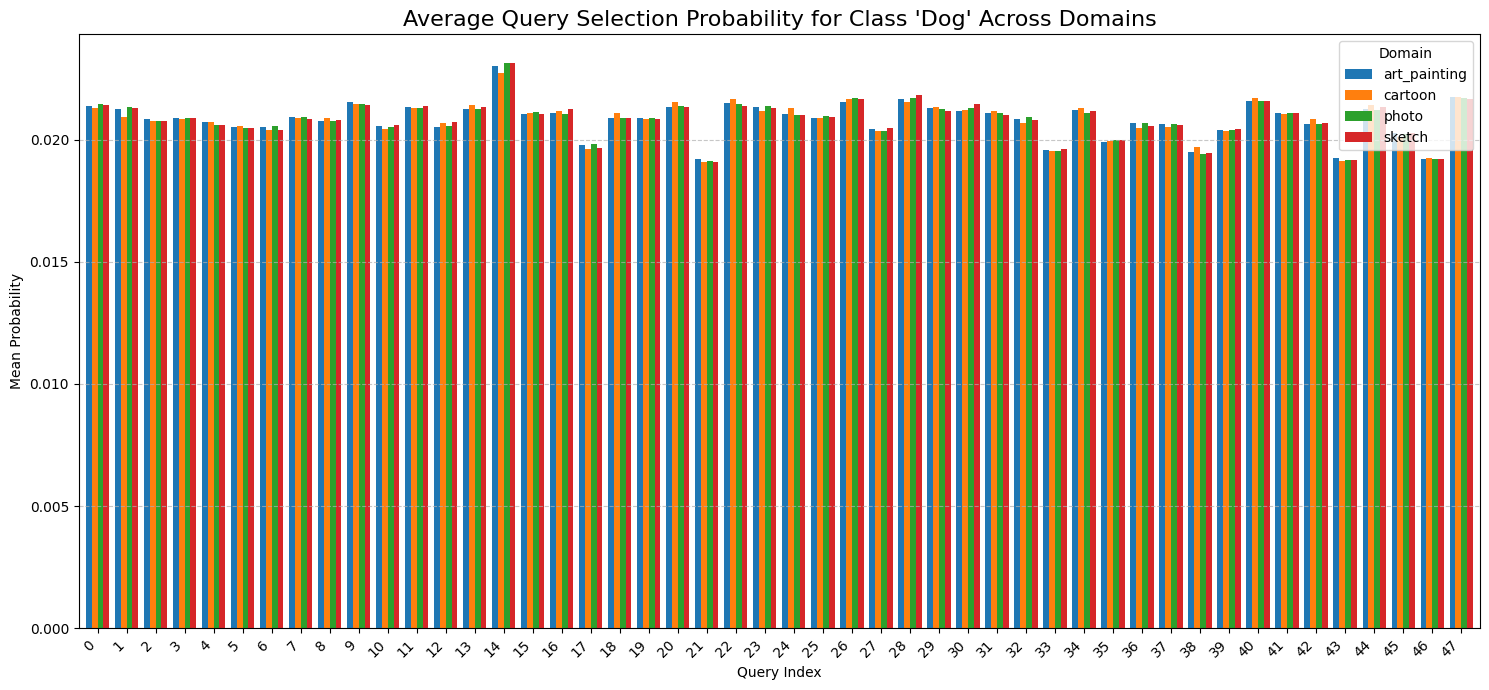

Saved probability score plot for class 'elephant' to c:\Users\Fatim_Sproj\Desktop\Fatim\Spring 2025\sproj\Visual-Reasoning\Vit-GRQO\resnet\PACS\plots\prob_scores_class_elephant.png


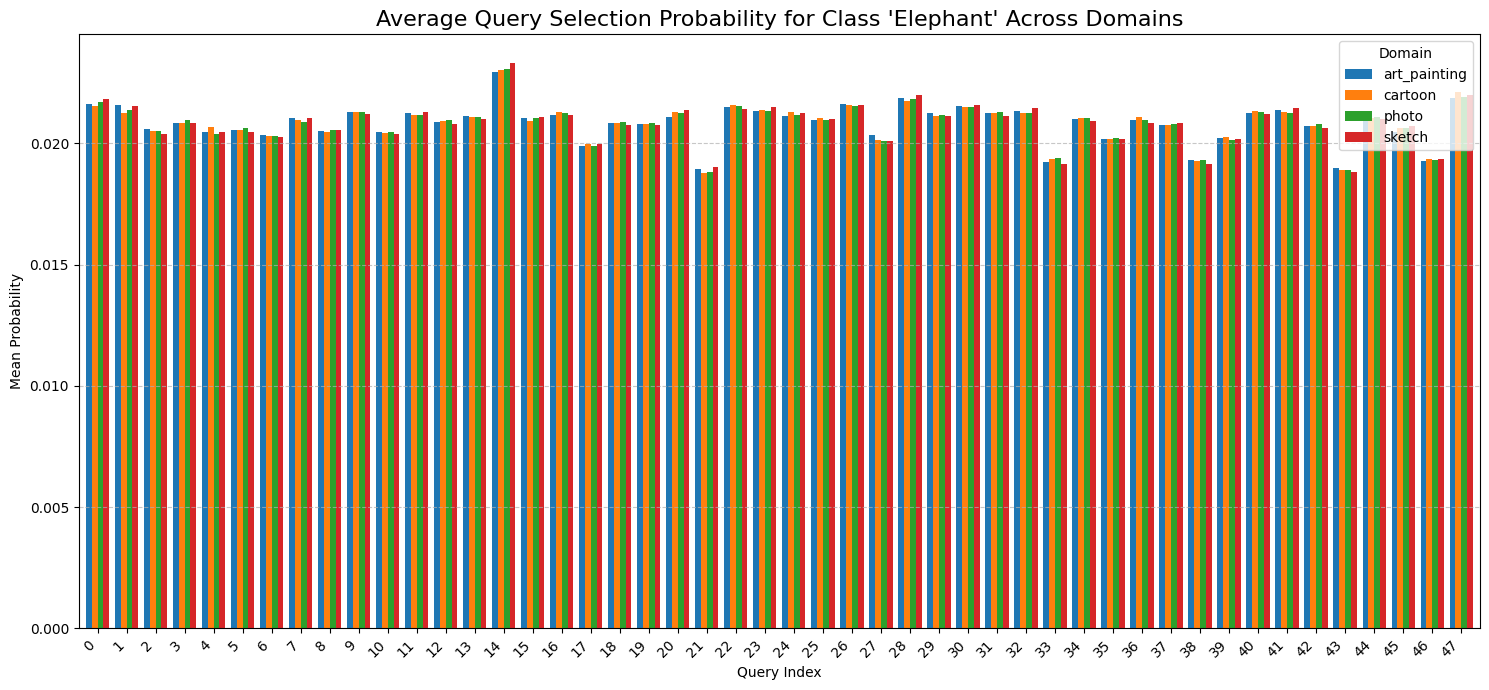

Saved probability score plot for class 'giraffe' to c:\Users\Fatim_Sproj\Desktop\Fatim\Spring 2025\sproj\Visual-Reasoning\Vit-GRQO\resnet\PACS\plots\prob_scores_class_giraffe.png


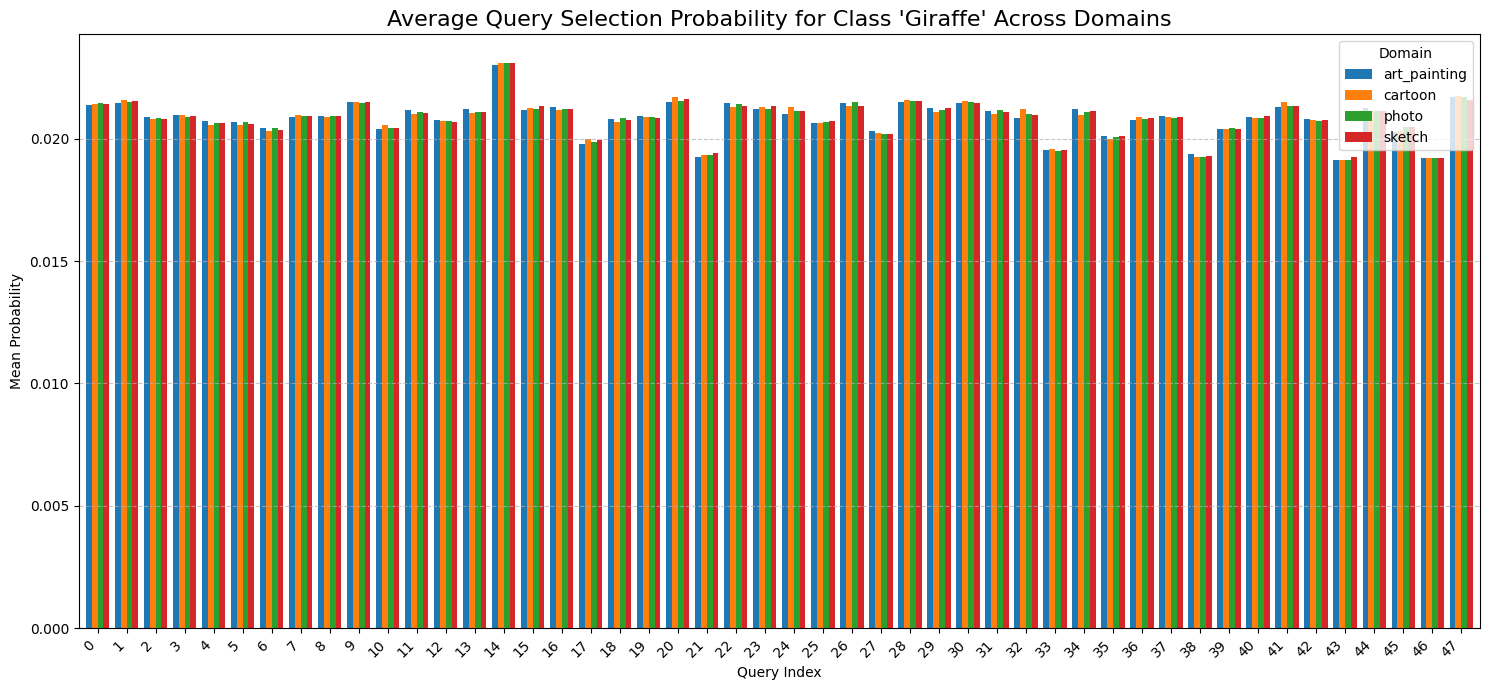

In [6]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- Test 1: Analyzing Consistency of Query Selection (prob_scores) ---")

# --- 1. Function to Collect Scores (Corrected) ---
def collect_scores_and_labels(model, data_loader, device):
    model.eval() # This is important for disabling dropout, etc.
    all_prob_scores = []
    all_labels = []
    # We remove `with torch.no_grad()` because the model's forward pass
    # internally requires gradient computation for the reward proxy.
    for images, labels in tqdm(data_loader, desc="Collecting scores"):
        images = images.to(device)
        output_dict = model(images, labels.to(device))
        all_prob_scores.append(output_dict['prob_scores'].cpu())
        all_labels.append(labels.cpu())
    return torch.cat(all_prob_scores), torch.cat(all_labels)

# --- 2. Load Model and Collect Data for Each Domain ---
model_path = os.path.join(ckpt_root, "all_domain_model.pth")
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model not found at {model_path}. Please ensure Part 1 ran successfully.")

test_model = get_model(CFG, dataset="PACS").to(device)
test_model.load_state_dict(torch.load(model_path, map_location=device), strict=False)

domain_scores = {}
for domain in domains:
    print(f"\nProcessing domain: {domain}")
    domain_test_loader = pacs.get_dataloader(domain, train=False)
    prob_scores, labels = collect_scores_and_labels(test_model, domain_test_loader, device)
    
    df = pd.DataFrame(prob_scores.numpy())
    df['label'] = labels.numpy()
    domain_scores[domain] = df

print("\nCollected query selection probabilities for all domains.")

# --- 3. Analyze and Visualize the Results ---
class_names = CFG['datasets']['PACS']['classes']
classes_to_analyze = [0, 1, 2] 

for class_idx in classes_to_analyze:
    plt.figure(figsize=(15, 7))
    
    mean_scores_by_domain = {
        domain: df[df['label'] == class_idx].iloc[:, :-1].mean().values
        for domain, df in domain_scores.items()
    }
    
    plot_df = pd.DataFrame(mean_scores_by_domain)
    plot_df.index.name = 'Query Index'
    
    plot_df.plot(kind='bar', width=0.8, ax=plt.gca())
    
    class_name = class_names[class_idx]
    plt.title(f"Average Query Selection Probability for Class '{class_name.capitalize()}' Across Domains", fontsize=16)
    plt.ylabel("Mean Probability")
    plt.xlabel("Query Index")
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title="Domain")
    plt.tight_layout()
    
    plot_path = os.path.join(plots_dir, f"prob_scores_class_{class_name}.png")
    plt.savefig(plot_path)
    print(f"Saved probability score plot for class '{class_name}' to {plot_path}")
    plt.show()


--- Test 2: Visualizing Cross-Attention Maps (Corrected) ---
Found example images for class 'dog' from all domains.


RuntimeError: shape '[14, 14]' is invalid for input of size 49

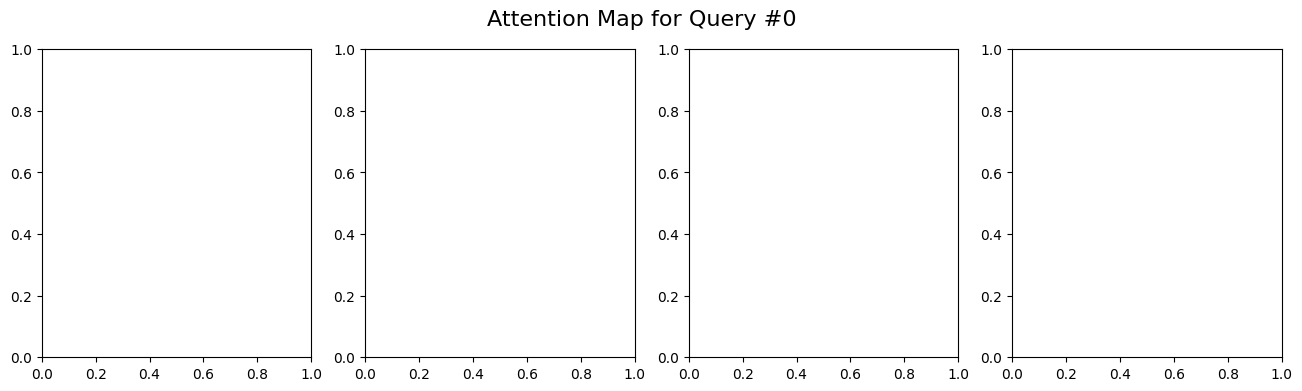

In [7]:
import torch
import torch.nn.functional as F
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import numpy as np

print("\n--- Test 2: Visualizing Cross-Attention Maps (Corrected) ---")

# --- 1. Load the Modified Model ---
# Ensure you have restarted the kernel after modifying the .py files
model_path = os.path.join(ckpt_root, "all_domain_model.pth")
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model not found at {model_path}. Please ensure Part 1 ran successfully.")

viz_model = get_model(CFG, dataset="PACS").to(device)
viz_model.load_state_dict(torch.load(model_path, map_location=device), strict=False)
viz_model.eval()

# --- 2. Get Example Images of the Same Class ---
class_to_find = 0 # We'll look for 'dog' (class 0)
class_name = CFG['datasets']['PACS']['classes'][class_to_find]
example_images = {}
example_found = True

for domain in domains:
    domain_dataset = pacs.get_dataset(domain, train=False)
    found_in_domain = False
    for i in range(len(domain_dataset)):
        img, label = domain_dataset[i]
        if label == class_to_find:
            example_images[domain] = img
            found_in_domain = True
            break
    if not found_in_domain:
        print(f"Warning: Could not find an image for class '{class_name}' in domain '{domain}'.")
        example_found = False

if not example_found:
    print("Could not find examples in all domains. Skipping attention visualization.")
else:
    print(f"Found example images for class '{class_name}' from all domains.")

    # --- 3. Visualization Function and Loop (Corrected) ---
    # --- CHANGE 1: Function now accepts class_idx ---
    def visualize_attention(model, image_tensor, query_idx_to_viz, class_idx, device, ax, title):
        image_tensor = image_tensor.unsqueeze(0).to(device)
        # --- CHANGE 2: Create a label tensor and pass it to the model ---
        label_tensor = torch.tensor([class_idx], device=device)
        
        # The model's forward pass now receives the correct label
        output_dict = model(image_tensor, labels=label_tensor)
        
        # Attention map shape: [Batch, Num_Queries, Num_Patches] -> [1, 32, 196]
        attn_map = output_dict['attention_map']

        # Get map for our query and reshape
        query_attn = attn_map[0, query_idx_to_viz, :].cpu() # Shape: [196]
        heatmap = query_attn.reshape(, 14)
        
        # Resize heatmap to original image size for overlay
        resized_heatmap = F.interpolate(heatmap.unsqueeze(0).unsqueeze(0),
                                        size=(224, 224),
                                        mode='bilinear',
                                        align_corners=False).squeeze()
        
        # Plotting
        img_pil = to_pil_image(image_tensor.squeeze(0).cpu())
        ax.imshow(img_pil)
        ax.imshow(resized_heatmap, cmap='viridis', alpha=0.6)
        ax.set_title(title, fontsize=10)
        ax.axis('off')

    # Visualize attention for a few different queries to see if they specialize
    queries_to_visualize = [0, 5, 31, 3, 12, 17, 24] 
    for query_idx in queries_to_visualize:
        fig, axes = plt.subplots(1, 4, figsize=(16, 4))
        fig.suptitle(f"Attention Map for Query #{query_idx}", fontsize=16)
        
        for ax, domain in zip(axes, domains):
            # --- CHANGE 3: Pass the class_to_find to the function ---
            visualize_attention(viz_model, example_images[domain], query_idx, class_to_find, device, ax, f"Domain: {domain.capitalize()}")
        
        plot_path = os.path.join(plots_dir, f"attention_query_{query_idx}.png")
        plt.savefig(plot_path)
        print(f"Saved attention map visualization for Query #{query_idx} to {plot_path}")
        plt.show()

In [ ]:
import torch
import torch.nn.functional as F
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import numpy as np

print("\n--- The Ultimate Test: Source vs. Unseen Target Domain Adaptation ---")

# --- 1. Get Example Images (Same as before) ---
class_to_find = 0 # 'dog'
class_name = CFG['datasets']['PACS']['classes'][class_to_find]
example_images = {}
for domain in domains:
    domain_dataset = pacs.get_dataset(domain, train=False)
    for i in range(len(domain_dataset)):
        img, label = domain_dataset[i]
        if label == class_to_find:
            example_images[domain] = img
            break

print(f"Found example images for class '{class_name}' from all domains.")

# --- 2. Visualization Function (Same as before) ---
def visualize_attention(model, image_tensor, query_idx_to_viz, class_idx, device, ax, title):
    image_tensor = image_tensor.unsqueeze(0).to(device)
    label_tensor = torch.tensor([class_idx], device=device)
    
    output_dict = model(image_tensor, labels=label_tensor)
    attn_map = output_dict['attention_map']
    query_attn = attn_map[0, query_idx_to_viz, :].cpu()
    heatmap = query_attn.reshape(14, 14)
    resized_heatmap = F.interpolate(heatmap.unsqueeze(0).unsqueeze(0),
                                    size=(224, 224),
                                    mode='bilinear',
                                    align_corners=False).squeeze()
    
    img_pil = to_pil_image(image_tensor.squeeze(0).cpu())
    ax.imshow(img_pil)
    ax.imshow(resized_heatmap, cmap='viridis', alpha=0.6)
    ax.set_title(title, fontsize=12)
    ax.axis('off')

# --- 3. The Source vs. Target Visualization Loop ---
queries_to_visualize = [3, 12, 17, 24]
source_domains_to_show = ["cartoon", "photo", "sketch", "art_painting"] # Define a consistent source for comparison

for query_idx in queries_to_visualize:
    # Create a 4x2 grid of plots. Each row corresponds to one LODO model.
    fig, axes = plt.subplots(4, 2, figsize=(8, 16))
    fig.suptitle(f"Source vs. Target Adaptation for Query #{query_idx}", fontsize=16, y=0.95)

    # Iterate through each LODO model, defined by its held-out (target) domain
    for i, target_domain in enumerate(domains):
        # --- Define Source and Target ---
        # Pick a source domain that is NOT the target domain
        source_domain = next(d for d in source_domains_to_show if d != target_domain)
        
        # --- Load the Correct LODO Model ---
        model_path = os.path.join(ckpt_root, f"best_{target_domain}.ckpt")
        if not os.path.exists(model_path):
            axes[i, 0].set_title(f"Model for {target_domain} not found")
            axes[i, 0].axis('off')
            axes[i, 1].set_title("")
            axes[i, 1].axis('off')
            continue
            
        lodo_model = get_model(CFG, dataset="PACS").to(device)
        lodo_model.load_state_dict(torch.load(model_path, map_location=device), strict=False)
        lodo_model.eval()

        # --- Visualize on Source Domain (Left Column) ---
        source_image = example_images[source_domain]
        source_title = f"Model w/o '{target_domain.capitalize()}'\nSees FAMILIAR '{source_domain.capitalize()}'"
        visualize_attention(lodo_model, source_image, query_idx, class_to_find, device, axes[i, 0], source_title)

        # --- Visualize on Target Domain (Right Column) ---
        target_image = example_images[target_domain]
        target_title = f"Model w/o '{target_domain.capitalize()}'\nSees UNSEEN '{target_domain.capitalize()}'"
        visualize_attention(lodo_model, target_image, query_idx, class_to_find, device, axes[i, 1], target_title)
    
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plot_path = os.path.join(plots_dir, f"ADAPTATION_query_{query_idx}.png")
    plt.savefig(plot_path)
    print(f"Saved Source vs. Target adaptation plot for Query #{query_idx} to {plot_path}")
    plt.show()